## Application: YOLO TIF CLASSIFICATION

In [1]:
from ultralytics import YOLO
from pathlib import Path
import rasterio
from rasterio.windows import Window
import geopandas as gpd
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm
import os

In [ ]:
# CONFIGURATION
MODEL_PATH = Path("../runs/greenery_classification/weights/best.pt")
GRID_PATH = Path("../data/grid/Msimbazi_merged_ycbr_filtered.gpkg")  
RAW_DATA_PATH = Path("../data/raw")
OUTPUT_PATH = Path("../results/classification_maps")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

TIF_FILE = "Msimbazi_Merged_ycbr.tif"

IMAGE_SIZE = 224
CONFIDENCE_THRESHOLD = 0.5
BATCH_SIZE = 64   # for prediction with GPU, a higher batch size here is usefull, bacause the prediction takes a little longer for all the cells

class TIFClassifier:
    def __init__(self, model_path, grid_path):
        print("Loading YOLO model...")
        # GPU 
        self.model = YOLO(str(model_path))
        self.model.to("cuda")

        print("Loading grid...")
        self.grid = gpd.read_file(grid_path)
        print(f"Grid loaded: {len(self.grid)} cells")

    def prepare_grid(self, tif_path):
        with rasterio.open(tif_path) as src:
            tif_crs = src.crs
            if self.grid.crs != tif_crs:
                grid_in_tif_crs = self.grid.to_crs(tif_crs)
            else:
                grid_in_tif_crs = self.grid.copy()
            return grid_in_tif_crs, tif_crs

    def extract_cell_image(self, src, cell_geom, target_size=IMAGE_SIZE):
        try:
            minx, miny, maxx, maxy = cell_geom.bounds
            row_start, col_start = src.index(minx, maxy)
            row_stop, col_stop = src.index(maxx, miny)
            if row_start > row_stop:
                row_start, row_stop = row_stop, row_start
            if col_start > col_stop:
                col_start, col_stop = col_stop, col_start
            window = Window(col_start, row_start, col_stop - col_start, row_stop - row_start)
            img_array = src.read([1, 2, 3], window=window)
            if img_array.size == 0:
                return None
            img_array = np.transpose(img_array, (1, 2, 0))
            if np.all(img_array == 0) or np.all(np.isnan(img_array)):
                return None
            if img_array.max() > 255:
                img_array = (img_array / img_array.max() * 255).astype(np.uint8)
            else:
                img_array = img_array.astype(np.uint8)
            img = Image.fromarray(img_array)
            img = img.resize((target_size, target_size), Image.LANCZOS)
            return img
        except:
            return None

    def process_tif(self, tif_path):
        grid_cells, tif_crs = self.prepare_grid(tif_path)
        results = []

        with rasterio.open(tif_path) as src:
            batch_imgs, batch_meta = [], []

            for idx, row in tqdm(grid_cells.iterrows(), total=len(grid_cells), desc="Classifying cells"):
                cell_img = self.extract_cell_image(src, row.geometry)
                if cell_img is not None:
                    batch_imgs.append(cell_img)
                    batch_meta.append((idx, row))

                # Wenn Batch voll ist → GPU Prediction
                if len(batch_imgs) == BATCH_SIZE:
                    preds = self.model.predict(batch_imgs, batch=BATCH_SIZE, device=0, verbose=False)
                    for img_idx, pred in enumerate(preds):
                        probs = pred.probs
                        top1_idx = probs.top1
                        conf = probs.top1conf.item()
                        class_name = "greenery" if top1_idx == 0 else "non_greenery"
                        idx, row = batch_meta[img_idx]
                        results.append({
                            'cell_id': idx,
                            'class': class_name,
                            'confidence': conf,
                            'geometry': row.geometry,
                            'grid_value': row.get('value', None)
                        })
                    batch_imgs, batch_meta = [], []

            # Restliche Bilder im letzten Batch
            if batch_imgs:
                preds = self.model.predict(batch_imgs, batch=BATCH_SIZE, device=0, verbose=False)
                for img_idx, pred in enumerate(preds):
                    probs = pred.probs
                    top1_idx = probs.top1
                    conf = probs.top1conf.item()
                    class_name = "greenery" if top1_idx == 0 else "non_greenery"
                    idx, row = batch_meta[img_idx]
                    results.append({
                        'cell_id': idx,
                        'class': class_name,
                        'confidence': conf,
                        'geometry': row.geometry,
                        'grid_value': row.get('value', None)
                    })

        results_gdf = gpd.GeoDataFrame(results, crs=tif_crs)
        valid_results = results_gdf[
            (results_gdf['class'].notna()) & (results_gdf['confidence'] >= CONFIDENCE_THRESHOLD)
        ].copy()
        return valid_results
    
    def save_results(self, results_gdf, tif_name):
        """Save classification results to GeoPackage and CSV."""
        if results_gdf is None or len(results_gdf) == 0:
            print("  No results to save!")
            return
        
        base_name = tif_name.replace('.tif', '')
        
        # Save as GeoPackage
        gpkg_path = OUTPUT_PATH / f"{base_name}_classified.gpkg"
        results_gdf.to_file(gpkg_path, driver="GPKG")
        print(f" Saved GeoPackage: {gpkg_path}")
        
        # Save as CSV (without geometry)
        csv_path = OUTPUT_PATH / f"{base_name}_classified.csv"
        results_df = pd.DataFrame(results_gdf.drop(columns='geometry'))
        results_df.to_csv(csv_path, index=False)
        print(f" Saved CSV: {csv_path}")
        
        # Create summary statistics
        summary = {
            'tif_name': tif_name,
            'total_cells': len(results_gdf),
            'greenery_cells': len(results_gdf[results_gdf['class'] == 'greenery']),
            'non_greenery_cells': len(results_gdf[results_gdf['class'] == 'non_greenery']),
            'greenery_percentage': len(results_gdf[results_gdf['class'] == 'greenery']) / len(results_gdf) * 100,
            'mean_confidence': results_gdf['confidence'].mean()
        }
        
        print(f"\n Classification Summary:")
        print(f"   Greenery: {summary['greenery_percentage']:.1f}%")
        print(f"   Mean confidence: {summary['mean_confidence']:.2%}")
        
        return summary

def main():
    """Main processing pipeline."""
    print("="*70)
    print(" YOLO TIF CLASSIFICATION - Msimbazi")
    print("="*70)
    
    # Check files exist
    if not MODEL_PATH.exists():
        print(f" Model not found: {MODEL_PATH}")
        return
    
    if not GRID_PATH.exists():
        print(f" Grid not found: {GRID_PATH}")
        return
    
    tif_path = RAW_DATA_PATH / TIF_FILE
    if not tif_path.exists():
        print(f" TIF not found: {tif_path}")
        return
    
    # Initialize classifier
    classifier = TIFClassifier(MODEL_PATH, GRID_PATH)
    
    # Process TIF
    results = classifier.process_tif(tif_path)
    
    # Save results
    if results is not None:
        summary = classifier.save_results(results, TIF_FILE)
        
        # Save summary
        summary_df = pd.DataFrame([summary])
        summary_path = OUTPUT_PATH / "Msimbazi_classification_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n Summary saved: {summary_path}")
    
    print(f"\n{'='*70}")
    print(" CLASSIFICATION COMPLETE!")
    print(f"{'='*70}")
    print(f"Results saved in: {OUTPUT_PATH}")

if __name__ == "__main__":
    main()


 YOLO TIF CLASSIFICATION - Msimbazi
Loading YOLO model...
Loading grid...
Grid loaded: 820965 cells


Classifying cells: 100%|██████████| 820965/820965 [53:37<00:00, 255.18it/s]  


 Saved GeoPackage: ..\results\classification_maps\Msimbazi_Merged_ycbr_classified.gpkg
 Saved CSV: ..\results\classification_maps\Msimbazi_Merged_ycbr_classified.csv

 Classification Summary:
   Greenery: 20.8%
   Mean confidence: 95.87%

 Summary saved: ..\results\classification_maps\Msimbazi_classification_summary.csv

 CLASSIFICATION COMPLETE!
Results saved in: ..\results\classification_maps


### Plotting classification results for Msimbazi

In [3]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21496\2104802463.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc='upper right', fontsize=12)
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21496\2104802463.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right', fontsize=12)


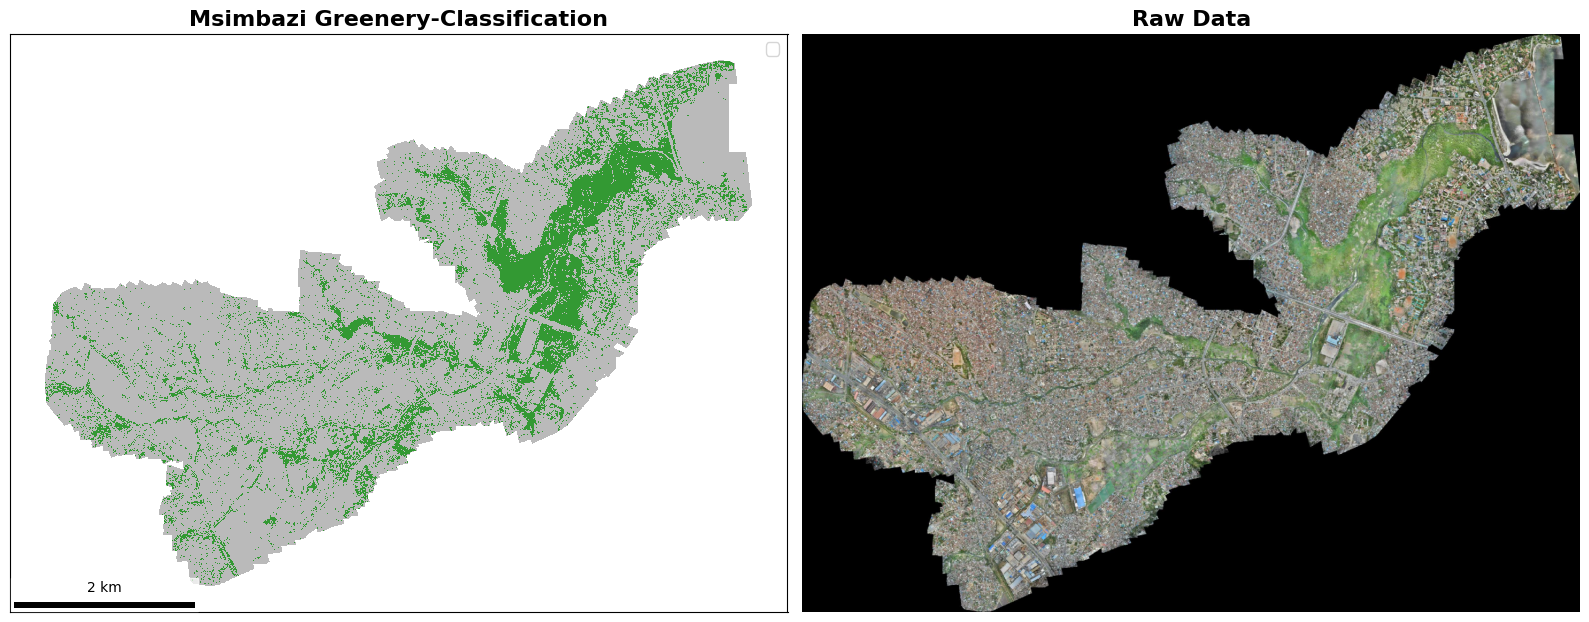

In [ ]:
# CONFIGURATION
OUTPUT_PATH = Path("../results/classification_maps") 
RAW_DATA_PATH = Path("../data/raw")
TIF_FILE = "Msimbazi_Merged_ycbr.tif"
CLASSIFIED_FILE = "Msimbazi_Merged_ycbr_classified.gpkg"
# Downsampling factor (Important for displaying large TIFs)
scale_factor = 0.01 

# DATA
# Load classification results
results_gdf = gpd.read_file(OUTPUT_PATH / CLASSIFIED_FILE)

# Load raw TIF data and downsample
tif_path = RAW_DATA_PATH / TIF_FILE
with rasterio.open(tif_path) as src:
    # Read the first 3 bands (RGB) with downsampling
    overview = src.read(
        [1, 2, 3], 
        out_shape=(
            3, 
            int(src.height * scale_factor), 
            int(src.width * scale_factor)
        )
    )
    
    # Convert (C, H, W) -> (H, W, C) for Matplotlib
    raw_data_rgb = overview.transpose((1, 2, 0))
    
# CREATE PLOT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Subplot 1: Classification Results
greenery = results_gdf[results_gdf['class'] == 'greenery']
non_greenery = results_gdf[results_gdf['class'] == 'non_greenery']

greenery.plot(ax=ax1, color='green', alpha=0.8, label='Greenery', edgecolor='none')
non_greenery.plot(ax=ax1, color='darkgray', alpha=0.8, label='Non-Greenery', edgecolor='none')

ax1.set_title('Msimbazi Greenery-Classification', fontsize=16, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.legend(loc='upper right', fontsize=12)

scalebar = ScaleBar(
    1,  
    'm',  
    length_fraction=0.25, 
    location='lower left',
    box_alpha=0.7,
    scale_loc='top'
)
ax1.add_artist(scalebar)

# Subplot 2: Raw Data 
ax2.imshow(raw_data_rgb)
ax2.axis('off')
ax2.set_title('Raw Data', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../results/Classification_maps/Classification_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Plotting Hotspot Identification for Msimbazi

In [6]:
greenery = gpd.read_file("../results/classification_maps/Msimbazi_Merged_ycbr_classified.gpkg")
buildings = gpd.read_file("../data/grid/Grid_Buildings_intersected.gpkg")

In [7]:
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21496\2155593415.py:53: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  analysis.plot(column='category', ax=axes[0], legend=False,
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21496\2155593415.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_b = plt.cm.get_cmap('YlOrRd', len(labels_b))
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21496\2155593415.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_g = plt.cm.get_cmap('Greens', len(labels_g))


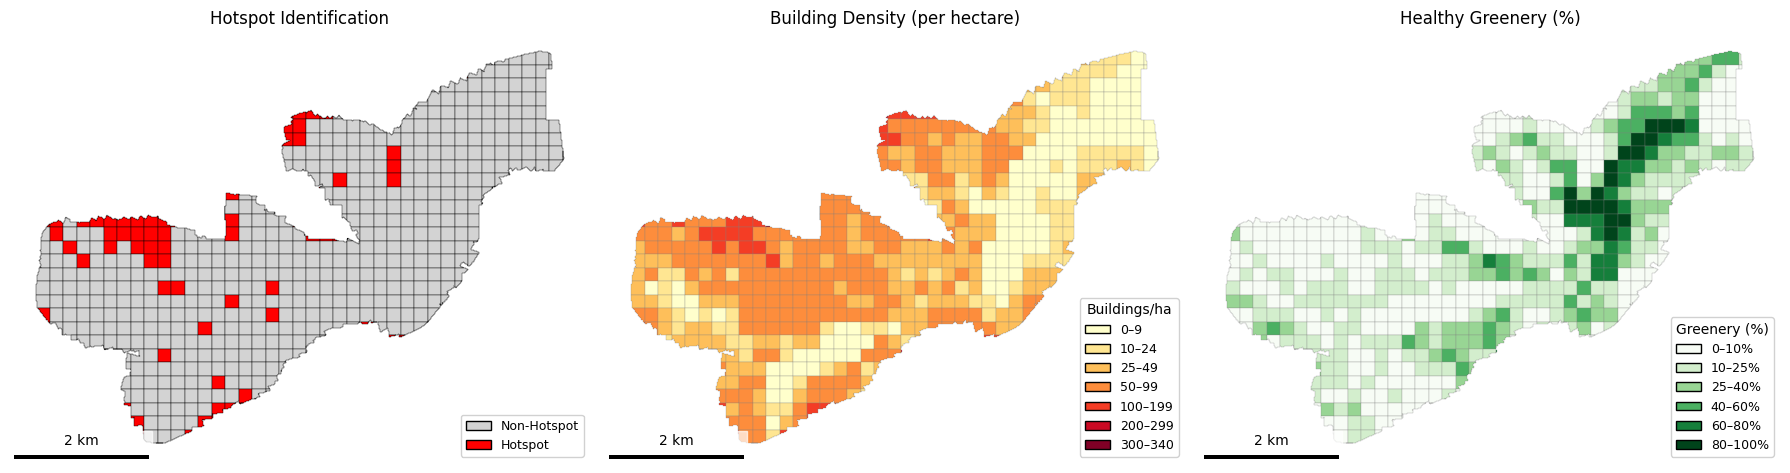

In [8]:
# Column names
greenery_col, building_col = 'class', 'density_count'
grid_id_col = 'id' if 'id' in buildings.columns else 'fid' if 'fid' in buildings.columns else None
if grid_id_col is None:
    buildings['grid_id'] = buildings.index
    grid_id_col = 'grid_id'

# Ensure numeric type
buildings[building_col] = pd.to_numeric(buildings[building_col], errors='coerce').fillna(0)

# Spatial join and aggregation
joined = gpd.sjoin(greenery, buildings[[grid_id_col, 'geometry']], how='left', predicate='within')
stats = joined.groupby(grid_id_col)[greenery_col].apply(lambda x: (x == 'greenery').sum())
total = joined.groupby(grid_id_col).size()
greenery_stats = pd.DataFrame({
    grid_id_col: stats.index,
    'greenery_count': stats.values,
    'total_cells': total.values
})
greenery_stats['greenery_percent'] = greenery_stats['greenery_count'] / greenery_stats['total_cells'] * 100

# Merge with building density
analysis = buildings.merge(greenery_stats[[grid_id_col, 'greenery_percent']], on=grid_id_col, how='left')
analysis['greenery_percent'] = analysis['greenery_percent'].fillna(0)

# Hotspot definition
high_b = analysis[building_col].quantile(0.75)
low_g = analysis['greenery_percent'].quantile(0.25)
analysis['hotspot'] = (analysis[building_col] >= high_b) & (analysis['greenery_percent'] <= low_g)

# Two classes only: hotspot vs non-hotspot
analysis['category'] = 'Non-Hotspot'
analysis.loc[analysis['hotspot'], 'category'] = 'Hotspot'

# Manual classes for density (buildings per hectare)
max_b = int(analysis[building_col].max())
bins_b = [0, 10, 25, 50, 100, 200, 300, max_b+1]
labels_b = [f"{bins_b[i]}–{bins_b[i+1]-1}" for i in range(len(bins_b)-1)]
analysis['density_class'] = pd.cut(analysis[building_col], bins=bins_b, labels=labels_b,
                                   include_lowest=True, right=False).astype(str)

# Manual classes for greenery
bins_g = [0, 10, 25, 40, 60, 80, 100.1]
labels_g = [f"{bins_g[i]}–{int(bins_g[i+1])}%" for i in range(len(bins_g)-1)]
analysis['greenery_class'] = pd.cut(analysis['greenery_percent'], bins=bins_g, labels=labels_g,
                                    include_lowest=True, right=False).astype(str)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Hotspot map
colors_hotspot = {'Non-Hotspot': 'lightgray', 'Hotspot': 'red'}
analysis.plot(column='category', ax=axes[0], legend=False,
              color=[colors_hotspot[c] for c in analysis['category']],
              edgecolor='black', linewidth=0.3)
axes[0].set_title('Hotspot Identification')
axes[0].axis('off')
legend_elements = [Patch(facecolor=v, edgecolor='black', label=k) for k, v in colors_hotspot.items()]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=9, framealpha=0.9)

# scalebar 1
scalebar1 = ScaleBar(
    1,  # 1 Meter per unit
    'm',
    length_fraction=0.25,
    location='lower left',
    box_alpha=0.7,
    scale_loc='top'
)
axes[0].add_artist(scalebar1)


# Building density map
cmap_b = plt.cm.get_cmap('YlOrRd', len(labels_b))
class_to_color_b = {lab: cmap_b(i) for i, lab in enumerate(labels_b)}
analysis.plot(ax=axes[1],
              color=analysis['density_class'].map(class_to_color_b),
              edgecolor='gray', linewidth=0.2)
axes[1].set_title('Building Density (per hectare)')
axes[1].axis('off')
legend_b = [Patch(facecolor=class_to_color_b[lab], edgecolor='black', label=lab) for lab in labels_b]
axes[1].legend(handles=legend_b, loc='lower right', fontsize=9, framealpha=0.9, title='Buildings/ha')

# scalebar 2
scalebar2 = ScaleBar(
    1,
    'm',
    length_fraction=0.25,
    location='lower left',
    box_alpha=0.7,
    scale_loc='top'
)
axes[1].add_artist(scalebar2)


# Greenery map
cmap_g = plt.cm.get_cmap('Greens', len(labels_g))
class_to_color_g = {lab: cmap_g(i) for i, lab in enumerate(labels_g)}
analysis.plot(ax=axes[2],
              color=analysis['greenery_class'].map(class_to_color_g),
              edgecolor='gray', linewidth=0.2)
axes[2].set_title('Healthy Greenery (%)')
axes[2].axis('off')
legend_g = [Patch(facecolor=class_to_color_g[lab], edgecolor='black', label=lab) for lab in labels_g]
axes[2].legend(handles=legend_g, loc='lower right', fontsize=9, framealpha=0.9, title='Greenery (%)')

# scalebar 3
scalebar3 = ScaleBar(
    1,
    'm',
    length_fraction=0.25,
    location='lower left',
    box_alpha=0.7,
    scale_loc='top'
)
axes[2].add_artist(scalebar3)


plt.tight_layout()
os.makedirs('../results/hotspots', exist_ok=True)
plt.savefig('../results/hotspots/hotspot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Export results
analysis.to_file('../results/hotspots/hotspot_analysis.gpkg', driver='GPKG')
if analysis['hotspot'].any():
    analysis.loc[analysis['hotspot']].to_file('../results/hotspots/hotspots_only.gpkg', driver='GPKG')

# Export statistics
pd.DataFrame({
    'Metric': [
        'Number of Grid Cells', 'Cells with Buildings', 'Cells without Buildings',
        'Number of Hotspots', 'Building Density Threshold (75% Quantile)',
        'Greenery Threshold (25% Quantile)', 'Max Building Density', 'Mean Greenery (%)'
    ],
    'Value': [
        len(analysis),
        (analysis[building_col] > 0).sum(),
        (analysis[building_col] == 0).sum(),
        analysis['hotspot'].sum(),
        float(high_b), float(low_g),
        int(analysis[building_col].max()),
        float(analysis['greenery_percent'].mean())
    ]
}).to_csv('../results/hotspots/hotspot_statistics.csv', index=False)